# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller  # untuk uji stationarity
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # untuk lihat ACF & PACF
from statsmodels.tsa.arima.model import ARIMA  # untuk membangun model ARIMA


## Sample data

In [ ]:
# # Dataset bulanan penumpang pesawat (1949-1960)
# from statsmodels.datasets import get_rdataset

# data = get_rdataset("AirPassengers")  # dataset bawaan R
# df = data.data
# df.to_csv("AirPassengers.csv")

In [ ]:
df = pd.read_csv('AirPassengers.csv')

In [3]:

# Rename kolom biar enak dibaca
df.columns = ["Month", "Passengers"]
df["Month"] = pd.to_datetime(df["Month"])
df.set_index("Month", inplace=True)

print(df.head())


                               Passengers
Month                                    
1970-01-01 00:00:00.000001949         112
1970-01-01 00:00:00.000001949         118
1970-01-01 00:00:00.000001949         132
1970-01-01 00:00:00.000001949         129
1970-01-01 00:00:00.000001949         121


In [4]:
df = df.copy()

# buat index bulanan mulai jan 1949, panjangnya = jumlah baris df
df.index = pd.date_range(start="1949-01-01", periods = len(df), freq = "M")

# set index jadi Month
df.index.name = "Month"

df.head()

C:\Users\liswy\AppData\Local\Temp\ipykernel_5476\467054691.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index = pd.date_range(start="1949-01-01", periods = len(df), freq = "M")


,Passengers
Month,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


# Visualiasi Awal

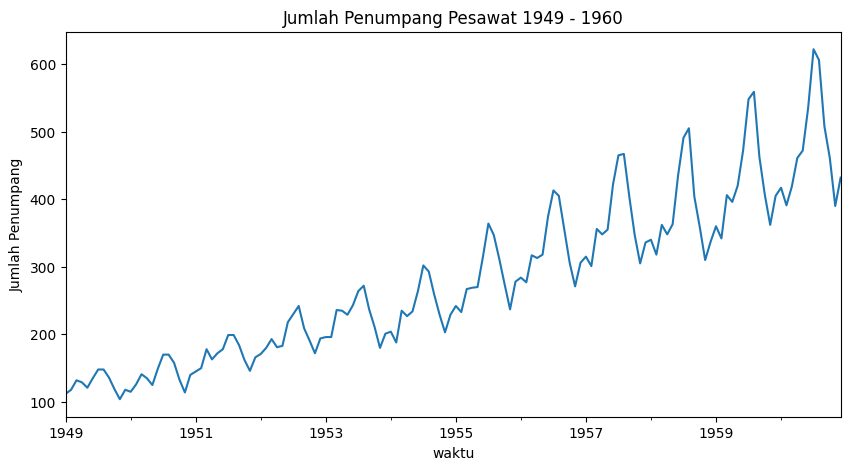

In [5]:
df["Passengers"].plot(figsize = (10,5), title = "Jumlah Penumpang Pesawat 1949 - 1960")
plt.ylabel("Jumlah Penumpang")
plt.xlabel("waktu")
plt.show()

# Uji stationarity (ADF Test)

In [11]:
result = adfuller(df["Passengers"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4]["5%"])

ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641
Critical Values: -2.8840418343195267


- H0 diterima hasil p-value lebih dari 0.05 yaitu 0.9918 yang berarti data tersebut non-stasioner.
- sesuai dengan hasil grafik yang dihasilkan ada pola trend naik dan juga seasonality.
- langkah selanjutnya kita akan melakukan differencing 1 kali d=1, bila data masih non-stasioner maka kita akan melakukan differencing lagi d=2.

In [7]:
result

(np.float64(0.8153688792060463),
 np.float64(0.991880243437641),
 13,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(996.692930839019))

# Differencing


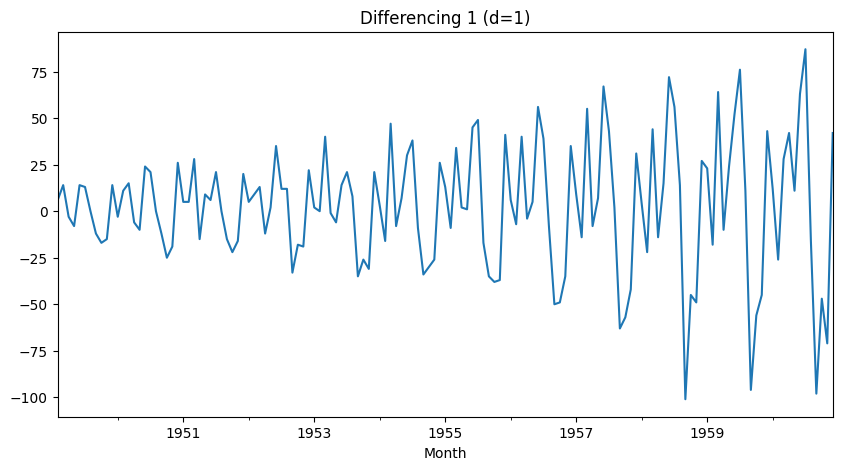

ADF Statistic (d=1) -2.8292668241699923
p-value (d=1) 0.054213290283826474
Critical Values (d=1) {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}


In [8]:
# Differencing pertama
df_diff = df["Passengers"].diff().dropna()

# Plot hasil differencing
df_diff.plot(figsize = (10, 5), title = "Differencing 1 (d=1)")
plt.show()

result_diff = adfuller(df_diff)
print("ADF Statistic (d=1)", result_diff[0])
print("p-value (d=1)", result_diff[1])
print("Critical Values (d=1)", result_diff[4])

- Dengan d=1, data sudah cukup “lebih stasioner” dibanding sebelumnya, tapi belum ideal di level 5%.

- Karena dataset ini musiman, biasanya kita butuh seasonal differencing juga (misal d=1 + D=1, m=12 untuk pola tahunan).

- Tapi sebelum masuk ke seasonal ARIMA (SARIMA), kita bisa coba differencing kedua (d=2) untuk lihat efeknya.

# Differencing 2 

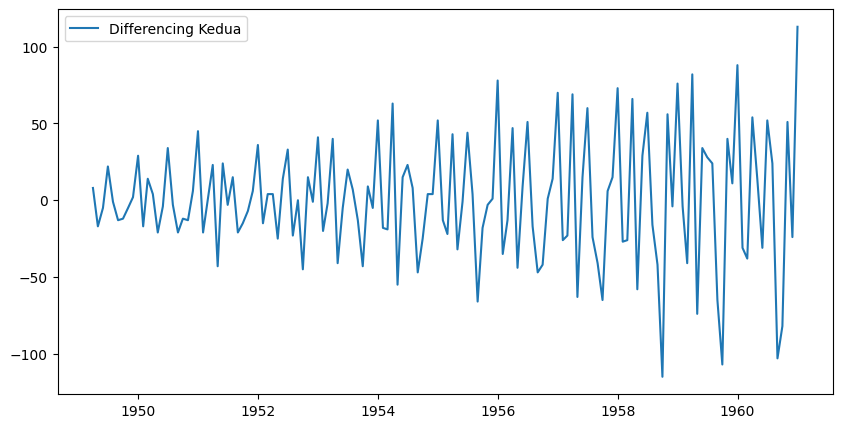

ADF Statistic:  -16.384231542468516
p-value:  2.7328918500141235e-29
Critical Values:  {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}


In [9]:
# differencing ke 2
df_diff2 = df_diff.diff().dropna()

# plot hasil differencing ke 2
plt.figure(figsize = (10, 5))
plt.plot(df_diff2, label = "Differencing Kedua")
plt.legend()
plt.show()

# Uji ADF setelah differencing ke 2
adf_result2 = adfuller(df_diff2)

print("ADF Statistic: ", adf_result2[0])
print("p-value: ", adf_result2[1])
print("Critical Values: ", adf_result2[4])


# Plot ACF dan PACF

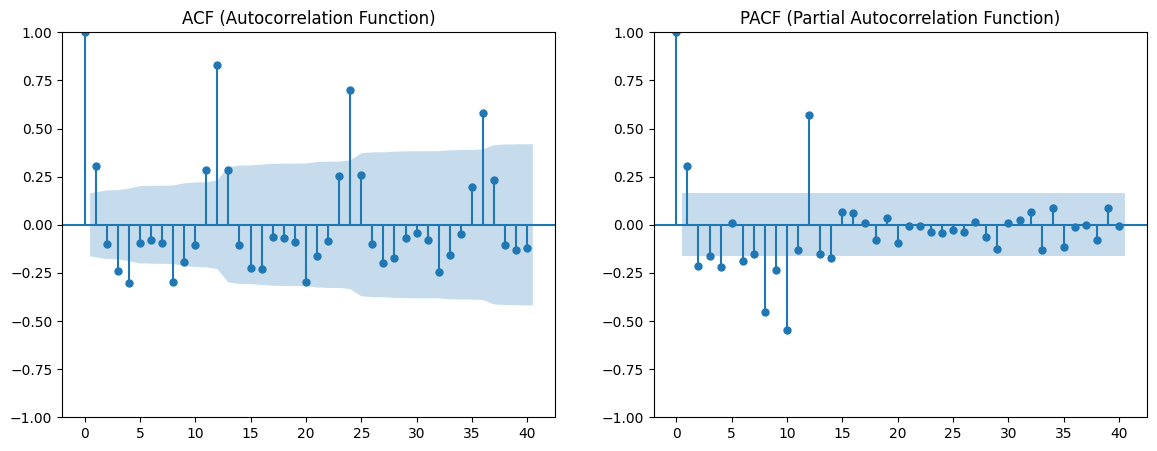

In [10]:
# Gunakan df_diff yang sudah ada
fig, axes = plt.subplots(1, 2, figsize=(14,5))

plot_acf(df_diff, ax=axes[0], lags=40)
axes[0].set_title("ACF (Autocorrelation Function)")

plot_pacf(df_diff, ax=axes[1], lags=40, method="ywm")
axes[1].set_title("PACF (Partial Autocorrelation Function)")

plt.show()
